In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from matplotlib.patches import Circle
import plotly.express as px
import networkx as nx
import itertools
from itertools import combinations
import rispy
import json
import os
from openai import OpenAI
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import re
from tqdm import tqdm
from upsetplot import from_memberships, UpSet

In [ ]:
openai_api_key = ''
client = OpenAI(api_key=openai_api_key)

In [3]:
keywords = ['Crypto', 'Cryptocurrency', 'Cryptocurrencies', 'Bitcoin', 'Ethereum']

dfs = {}
for keyword in keywords:
    file_name = f'Scopus/Scopus_{keyword}.csv'
    dfs[keyword] = pd.read_csv(file_name)

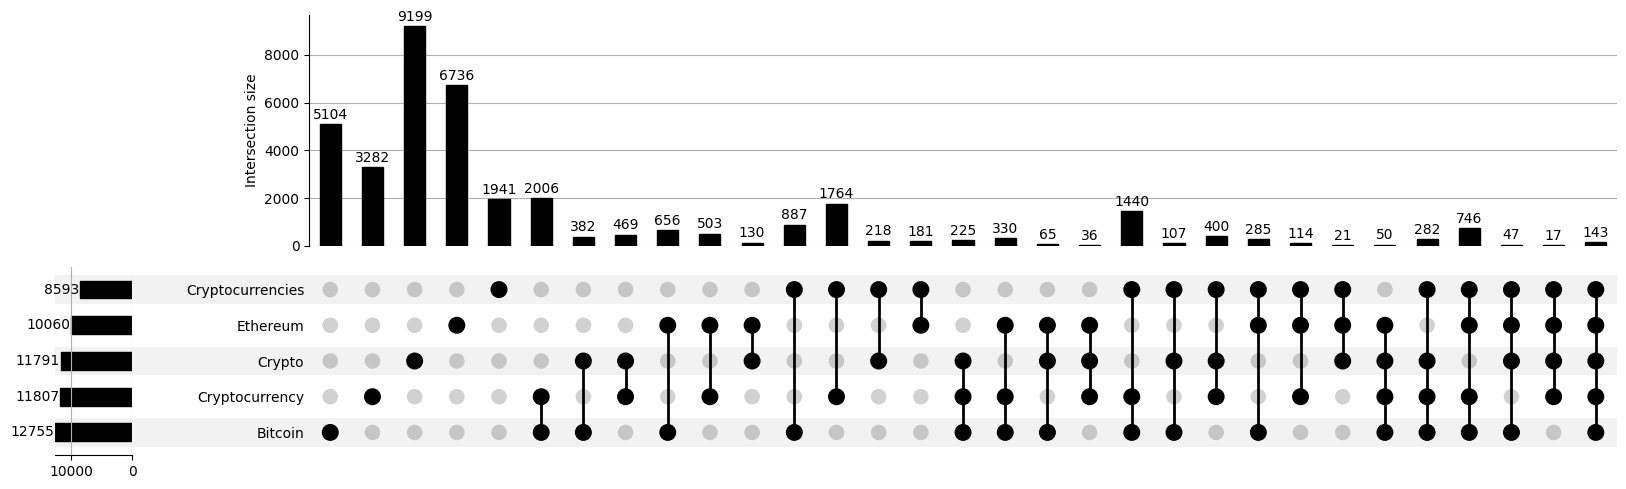

In [12]:
record_sets = {}

for keyword in keywords:
    df = dfs[keyword]
    ids = df.apply(lambda x: x['EID'] if pd.notna(x['EID']) and x['EID'].strip() != '' else x['Title'], axis=1).str.lower().str.strip()
    for i in ids:
        if i not in record_sets:
            record_sets[i] = set()
        record_sets[i].add(keyword)

memberships = list(record_sets.values())
data = from_memberships(memberships)

fig = plt.figure()
UpSet(data, subset_size='count', show_counts=True).plot(fig=fig)
fig.subplots_adjust(left=0.05, right=1, top=0.95, bottom=0.05)
plt.savefig('Results/Scopus UpSet Plot.png', dpi=144, transparent=True)
plt.show()

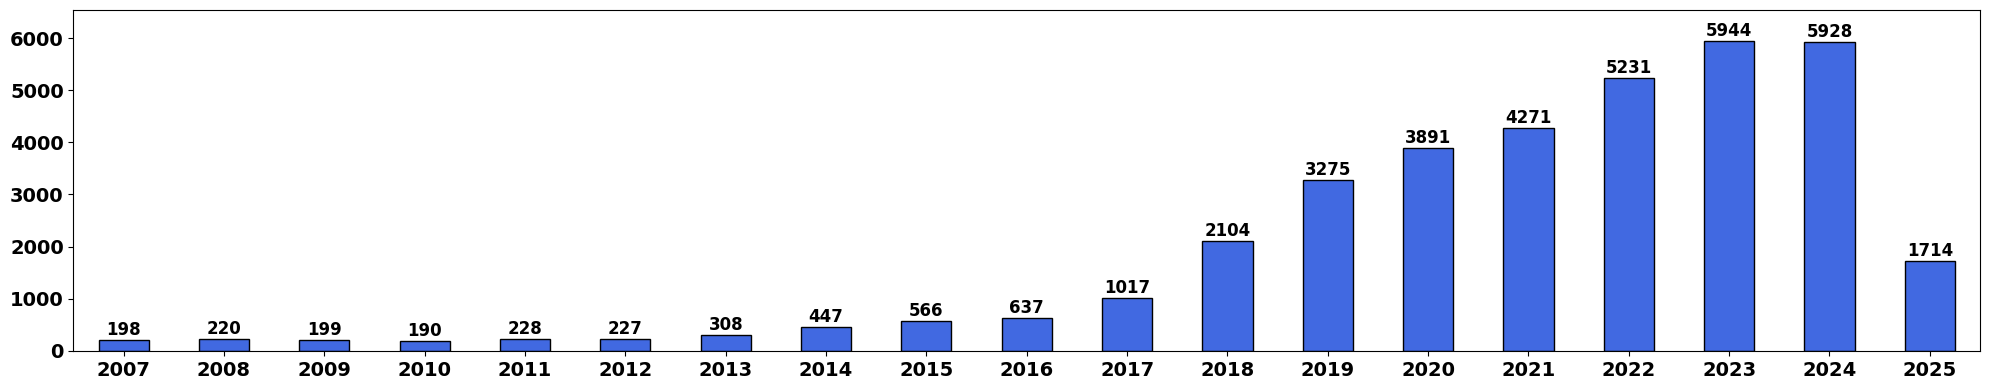

In [42]:
publication_trends = df['Year']
publication_trends = publication_trends[publication_trends >= 2007]
publication_trends = publication_trends.value_counts().sort_index()

plt.figure(figsize=(20, 4))
publication_trends.plot(kind='bar', color='royalblue', edgecolor='black')

for x, y in enumerate(publication_trends.values):
    plt.text(x, y + 20, str(y), fontsize=12, fontweight='heavy', ha='center', va='bottom', color='black')
plt.xticks(ticks=range(len(publication_trends.index)), labels=publication_trends.index, rotation=0, fontsize=14, fontweight='heavy')
plt.yticks(fontsize=14, fontweight='heavy')
plt.xlabel(None)
plt.ylim(-10, publication_trends.max() * 1.1)
plt.tight_layout()
plt.savefig('Results/Publication Year.png', dpi=144, transparent=True)
plt.show()

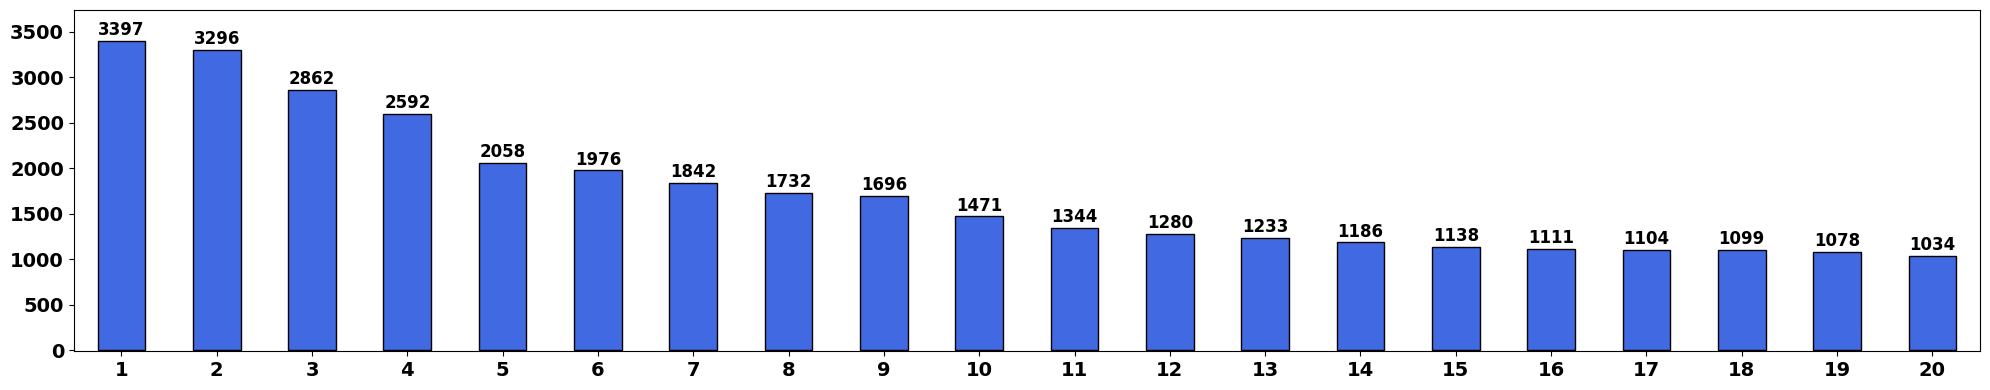

In [43]:
top_cited = df.sort_values(by='Cited by', ascending=False).head(20)
top_cited = top_cited.set_index('Title')  # Title 為 x 軸 index

plt.figure(figsize=(20, 4))
ax = top_cited['Cited by'].plot(kind='bar', color='royalblue', edgecolor='black')

for x, y in enumerate(top_cited['Cited by']):
    plt.text(x, y + 20, str(y), fontsize=12, fontweight='heavy', ha='center', va='bottom', color='black')

plt.xticks(ticks=range(len(top_cited)), labels=range(1, 21), rotation=0, fontsize=14, fontweight='heavy')
plt.yticks(fontsize=14, fontweight='heavy')
plt.xlabel(None)
plt.ylim(-10, top_cited['Cited by'].max() * 1.1)
plt.tight_layout()
plt.savefig('Results/Top Cited.png', dpi=144, transparent=True)
plt.show()

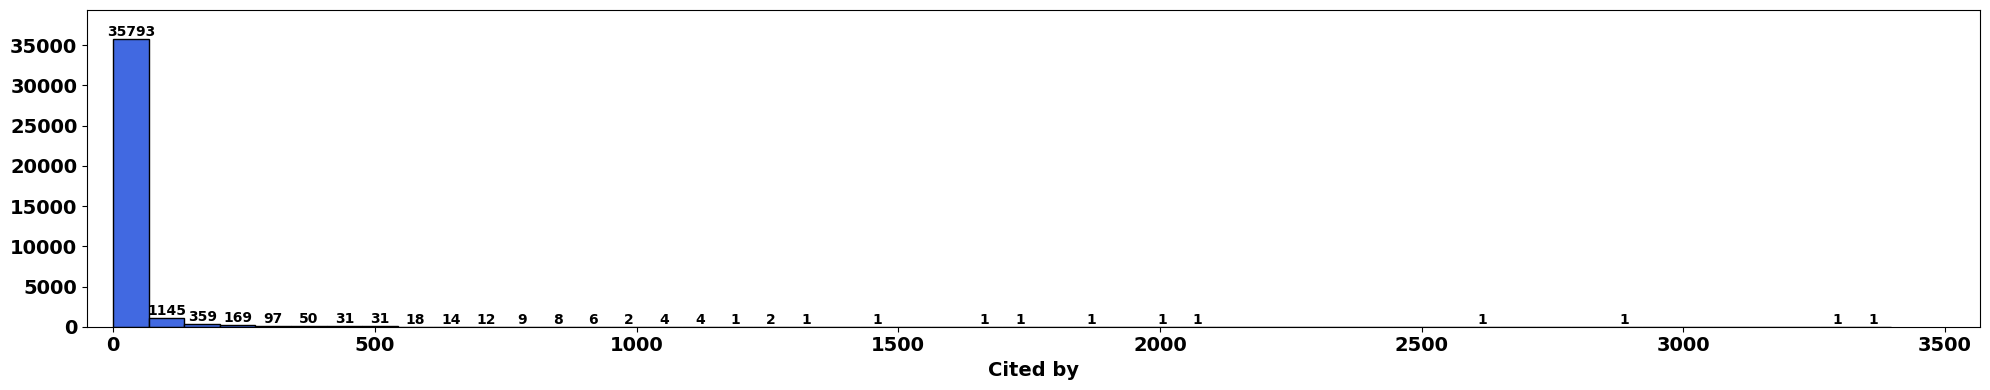

In [44]:
plt.figure(figsize=(20, 4))
counts, bins, patches = plt.hist(df['Cited by'].dropna(), bins=50, color='royalblue', edgecolor='black')

for x, y in zip((bins[:-1] + bins[1:]) / 2, counts):
    if y > 0:
        plt.text(x, y + 1, str(int(y)), ha='center', va='bottom', fontsize=10, fontweight='heavy', color='black')

plt.xticks(fontsize=14, fontweight='heavy')
plt.yticks(fontsize=14, fontweight='heavy')
plt.xlabel('Cited by', fontsize=14, fontweight='heavy')
plt.ylim(0, counts.max() * 1.1)
plt.xlim(-50,)
plt.tight_layout()
plt.savefig('Results/Cited by Distribution.png', dpi=144, transparent=True)
plt.show()

# OpenAI API Classification

In [ ]:
openai_api_key = ''
client = OpenAI(api_key=openai_api_key)

In [46]:
df_evaluated = df.copy()
df_evaluated = df_evaluated[df_evaluated['Cited by'] > 5]
df_evaluated = df_evaluated[df_evaluated['Year'] < 2024]

for col in ['Asset Allocation', 'Indexing', 'Bubbles', 'Valuation Models', 'Trading', 'Relative', 'Quality', 'Innovation', 'Timeliness']:
    df_evaluated[col] = np.nan

In [47]:
my_paper_title = """"Crypto Currency Returns": A Systematic Review"""
my_paper_abstract = """2024 marks a significant milestone in integrating digital finance into the global financial landscape. The SEC’s approval of Bitcoin and Ethereum ETFs highlights the ongoing and rapid digital finance trend. This paper provides a systematic review of existing research on "Crypto Currency Returns," employing updated datasets to examine the effectiveness and robustness. By constructing a comprehensive framework, this paper aims to paint a complete blueprint that connects the past, present, and future to illustrate the remarkable journey of Crypto Currency “Returns.”"""
my_paper_keywords = "Cryptocurrencies, Asset Allocation, Speculative Bubbles, Valuation Models, Index Construction, Digital Finance, Systematic Review"
my_paper_authors = "Siang-Li Jheng, Doctoral School of Cybernetics and Economic Statistics, Bucharest University of Economic Studies, Romania; Alexandra Conda, Doctoral School of Cybernetics and Economic Statistics, Bucharest University of Economic Studies, Romania; Daniel Traian Pele, Department of Statistics and Econometrics, Faculty of Cybernetics, Statistics and Economic Informatics, Bucharest University of Economic Studies, Bucharest, Romania; Wolfgang Härdle, Humboldt-Universit zu Berlin, Berlin, Germany, Bucharest University of Economic Studies, Bucharest, Romania; Huei-Wen Teng, National Yang Ming Chiao Tung University"

In [ ]:
for idx, row in tqdm(df_evaluated.iterrows(), total=df_evaluated.shape[0]):
# for idx, row in tqdm(df_evaluated.iloc[14300:].iterrows()):
    paper_title = row["Title"]
    paper_authors = row["Author full names"]
    paper_institution = row["Authors with affiliations"]
    paper_year = row["Year"]
    paper_journal = row["Source title"]
    paper_cited = row["Cited by"]
    paper_abstract = row["Abstract"]
    paper_keywords = row["Author Keywords"], row["Index Keywords"]

    prompt = f"""
    **Provide STRICT JSON output only**

    # My Paper Context
    Title: {my_paper_title}
    Abstract: {my_paper_abstract}
    Keywords: {my_paper_keywords}
    Authors: {my_paper_authors}

    ---

    # Instructions
    As an expert in finance and economics with focus on Crypto Currency Returns, evaluate the relevance of the following paper to the specified subtopics and provide a scoring form that follows a 10-point Likert scale from 1 (very low) to 10 (very high).
    
    Use the following criteria to evaluate topic relevance (1.~5.) and the value in different aspects (a~e):

    1. Asset Allocation – Includes portfolio optimization, analysis of asset class distinctions or co-movements across financial instruments... etc.
    2. Indexing - Develop risk index for cryptocurrencies.
    3. Speculative Bubbles - Address Speculative Bubbles, Bubble Models... etc.
    4. Valuation Models - Regulations, Digital Gold, and Valuation of Financial Services... etc.
    5. Trading - Include Arbitrage, Exchanges, Derivatives, Option Pricing Models... etc.

    a. Relative - Alignment with "{my_paper_title}" focus, based on the abstract from "My Paper Context"
    b. Quality - Considering the journal's rank, the authors' reputation and their institution.
    c. Innovation - Novel approach, data, or perspective on a known problem.
    d. Timeliness - Not only considering not only how recent the paper is, but also taking into account current popular trends and technological developments.
    e. Reproducibility - Data/code/methodology availability for replication


    **Please ONLY provide your evaluation in the following JSON format, NO need to provide any other response**:
    {{
        "Asset Allocation": score,
        "Indexing": score,
        "Bubbles": score,
        "Valuation Models": score,
        "Trading": score,
        "Relative": score,
        "Quality": score,
        "Innovation": score,
        "Timeliness": score
    }} 

    ---

    Paper Information:

    Title: {paper_title}
    Published Year: {paper_year}
    Author: {paper_authors}
    Institution: {paper_institution}
    Published Journal: {paper_journal}
    Cited Number: {paper_cited}
    Abstract:
    {paper_abstract}
    Keywords: {paper_keywords}

    **Provide STRICT JSON output only**
    """

    response = client.chat.completions.create(
        # model = "gpt-4o-mini-2024-07-18",
        model = "gpt-4.1-nano-2025-04-14",
        messages=[
            {"role": "system", "content": "You need to evaluate the paper based on the given criteria."},
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )

    reply = response.choices[0].message.content
    cleaned_reply = re.sub(r'```json|```', '', reply).strip()
    scores = json.loads(cleaned_reply)

    try:
        scores = json.loads(cleaned_reply)
    except json.JSONDecodeError:
        scores = {}

    if scores:
        for key in ['Asset Allocation', 'Indexing', 'Bubbles', 'Valuation Models',
                    'Trading', 'Relative', 'Quality', 'Innovation', 'Timeliness']:
            df_evaluated.at[idx, key] = scores.get(key, np.nan)

308it [05:18,  1.04s/it]


In [78]:
df_evaluated.to_csv('Scopus_Evaluated.csv')

In [202]:
df_sort = df_evaluated.copy()

df_sort = df_sort.drop(columns=["Cite", "URL", "Sources"])
df_sort['Cited By Normalized'] = df_sort['Cited By'].rank(pct=True) * 100

topics = ["Asset Allocation", "Indexing", "Bubbles", "Valuation Models", "Trading"]
weights = {"topic": 0.3, "Relative": 0.3, "Author Reputation": 0.1, "Innovation": 0.1, "Timeliness": 0.1, "Cited By Normalized": 0.1}

for topic in topics:
    df_sort[f"Weighted"] = (
        df_sort[topic] * weights["topic"] +
        df_sort["Relative"] * weights["Relative"] +
        df_sort["Author Reputation"] * weights["Author Reputation"] +
        df_sort["Innovation"] * weights["Innovation"] +
        df_sort["Timeliness"] * weights["Timeliness"] + 
        df_sort["Cited By Normalized"] * weights["Cited By Normalized"]
    )
    df_sort[f"Weighted"] = df_sort[f"Weighted"].round(1)
    sorted_df = df_sort.sort_values(by=f"Weighted", ascending=False)
    
    sorted_df.to_csv(f"CC Returns Sorted ({topic}).csv", index=False)

# Keywords + OpenAI API

In [31]:
keywords = df["Keywords"].str.split("; ").explode()
keywords_uniq = keywords.unique()
keywords_total = len(keywords_uniq)

In [3]:
# Loading RIS file
def load_ris(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        file_content = file.read()
    ris_entries = rispy.loads(file_content)
    df = pd.DataFrame(ris_entries)
    # Authors
    df['authors'] = df['authors'].apply(lambda x: x if isinstance(x, list) else [])
    # Cited number
    df['cited_by'] = df['notes'].apply(extract_cited_by)
    # Dealing with 'year'
    df['year'] = pd.to_numeric(df['year'], errors='coerce').fillna(0).astype(int)
    # Dealing with 'keywords'
    df['keywords'] = df['keywords'].apply(lambda x: x if isinstance(x, list) else [])
    return df

# Capture the 'Cited By' data
def extract_cited_by(notes):
    if notes:
        for note in notes:
            if "Cited By:" in note:
                try:
                    return int(note.split("Cited By: ")[1])
                except:
                    return 0

In [4]:
file_path = "scopus.ris"
df = load_ris(file_path)
df.head()

,type_of_reference,authors,title,year,secondary_title,volume,custom7,doi,urls,type_of_work,name_of_database,notes,number,keywords,start_page,end_page,short_title,cited_by
0,JOUR,"[Nguyen, B.K.Q., Pham, D.T.N.]",Investing during a Fintech revolution: The hed...,2025,Research in International Business and Finance,73,102599,10.1016/j.ribaf.2024.102599,[https://www.scopus.com/inward/record.uri?eid=...,Article,Scopus,[Export Date: 01 November 2024; Cited By: 0],NaN,[],NaN,NaN,NaN,0
1,JOUR,"[Cornell, C., Mitchell, L., Roughan, M.]",Rank is all you need: development and analysis...,2024,Applied Network Science,9,39,10.1007/s41109-024-00648-w,[https://www.scopus.com/inward/record.uri?eid=...,Article,Scopus,[Export Date: 01 November 2024; Cited By: 0],1,"[Electronic money, Finance, Regression analysi...",NaN,NaN,NaN,0
2,JOUR,"[Conlon, T., Corbet, S., Hou, Y.G., Hu, Y., La...",Understanding sentiment shifts in central bank...,2024,Journal of Behavioral and Experimental Finance,44,100988,10.1016/j.jbef.2024.100988,[https://www.scopus.com/inward/record.uri?eid=...,Article,Scopus,[Export Date: 01 November 2024; Cited By: 0],NaN,[],NaN,NaN,NaN,0
3,JOUR,"[Omole, O., Enke, D.]",Deep learning for Bitcoin price direction pred...,2024,Financial Innovation,10,117,10.1186/s40854-024-00643-1,[https://www.scopus.com/inward/record.uri?eid=...,Article,Scopus,[Export Date: 01 November 2024; Cited By: 0],1,[],NaN,NaN,NaN,0
4,JOUR,"[Yao, Y., Shi, Y., Tian, G., Miao, M., Susilo,...",PSCBO: A provably secure consensus-based block...,2025,Computer Standards and Interfaces,91,103892,10.1016/j.csi.2024.103892,[https://www.scopus.com/inward/record.uri?eid=...,Review,Scopus,[Export Date: 01 November 2024; Cited By: 0],NaN,"[Blockchain, Fault tolerance, Markov processes...",NaN,NaN,NaN,0


In [5]:
type_of_reference_categories = df['type_of_reference'].unique()
type_of_work_categories = df['type_of_work'].unique()

print(f"type_of_reference: {type_of_reference_categories}")
print(f"type_of_work: {type_of_work_categories}")

type_of_reference: ['JOUR' 'CHAP' 'CONF' 'BOOK']
type_of_work: ['Article' 'Review' 'Book chapter' 'Conference paper' 'Editorial' 'Book'
 'Erratum' 'Conference review' 'Short survey' 'Note' 'Letter' 'Data paper'
 'Retracted']


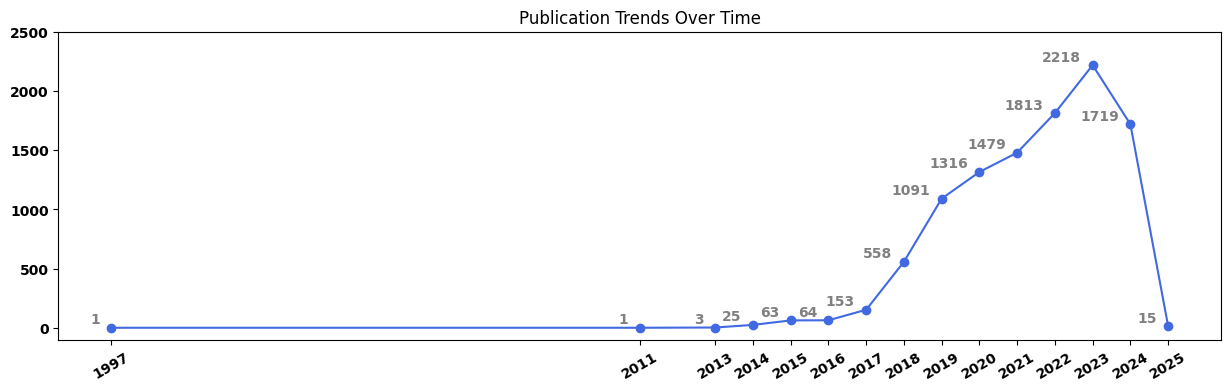

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 假設 df 已載入且包含 year 欄位

# 計算每年的出版數量
publication_trends = df['year'].value_counts().sort_index()

# 繪製出版趨勢的折線圖
plt.figure(figsize=(15, 4))
publication_trends.plot(kind='line', marker='o', color='royalblue')
for x, y in zip(publication_trends.index, publication_trends.values):
    plt.text(x-0.3, y+10, str(y), fontsize=10, fontweight='heavy', ha='right', va='bottom', color='gray')
plt.title('Publication Trends Over Time')
plt.xticks(ticks=publication_trends.index, labels=publication_trends.index, rotation=30, fontsize=10, fontweight='heavy')
plt.yticks(fontsize=10, fontweight='heavy')
plt.xlabel(None)
plt.ylim(-100, 2500)
plt.show()

In [7]:
df_early = df[df['year'].isin([1997, 2011])]
df_early

,type_of_reference,authors,title,year,secondary_title,volume,custom7,doi,urls,type_of_work,name_of_database,notes,number,keywords,start_page,end_page,short_title,cited_by
10505,CONF,"[Liśkiewicz, M.]",Interactive proof systems with public coin: Lo...,1997,Lecture Notes in Computer Science (including s...,1200,NaN,10.1007/bfb0023454,[https://www.scopus.com/inward/record.uri?eid=...,Conference paper,Scopus,[Export Date: 01 November 2024; Cited By: 3],NaN,"[Polynomial approximation, Turing machines, Co...",129,140,NaN,3
10515,JOUR,"[Surowiecki, J.]",Economics: Cryptocurrency,2011,Technology Review,114,NaN,NaN,[https://www.scopus.com/inward/record.uri?eid=...,Review,Scopus,[Export Date: 01 November 2024; Cited By: 5],5,"[Engineering, Technology, Alternative currency...",106,107,NaN,5


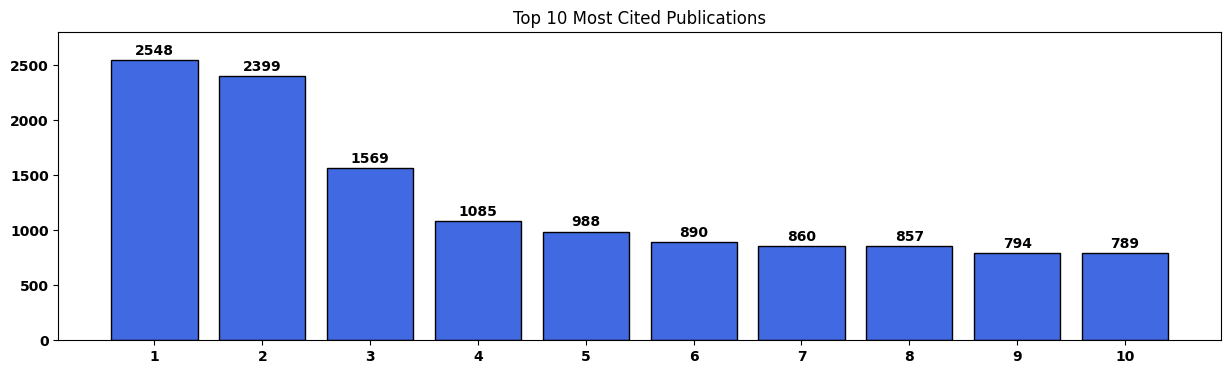

,title,year,authors,cited_by
10125,Blockchain challenges and opportunities: A survey,2018,"[Zheng, Z., Xie, S., Dai, H.-N., Chen, X., Wan...",2548
9912,Hyperledger Fabric: A Distributed Operating Sy...,2018,"[Androulaki, E., Barger, A., Bortnikov, V., Mu...",2399
10399,Where is current research on Blockchain techno...,2016,"[Yli-Huumo, J., Ko, D., Choi, S., Park, S., Sm...",1569
10244,Algorand: Scaling Byzantine Agreements for Cry...,2017,"[Gilad, Y., Hemo, R., Micali, S., Vlachos, G.,...",1085
7742,A survey on the security of blockchain systems,2020,"[Li, X., Jiang, P., Chen, T., Luo, X., Wen, Q.]",988
10488,The Bitcoin backbone protocol: Analysis and ap...,2015,"[Garay, J., Kiayias, A., Leonardos, N.]",890
10337,The inefficiency of Bitcoin,2016,"[Urquhart, A.]",860
10240,On the hedge and safe haven properties of Bitc...,2017,"[Bouri, E., Molnár, P., Azzi, G., Roubaud, D.,...",857
9907,A Review on the Use of Blockchain for the Inte...,2018,"[Fernández-Caramés, T.M., Fraga-Lamas, P.]",794
10514,Majority is not enough: Bitcoin mining is vuln...,2014,"[Eyal, I., Sirer, E.G.]",789


In [8]:
top_10_cited = df.sort_values(by='cited_by', ascending=False).head(10)

plt.figure(figsize=(15, 4))
bars = plt.bar(range(len(top_10_cited)), top_10_cited['cited_by'], color='royalblue', edgecolor='black')
plt.title('Top 10 Most Cited Publications')

for bar, cited_by in zip(bars, top_10_cited['cited_by']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+20, str(cited_by),
             ha='center', va='bottom', fontsize=10, fontweight='heavy')

plt.xticks(range(len(top_10_cited)), range(1, 11), fontsize=10, fontweight='heavy')
plt.yticks(fontsize=10, fontweight='heavy')
plt.ylim(0, 2800)
plt.show()

pd.DataFrame(top_10_cited[['title', 'year', 'authors', 'cited_by']])

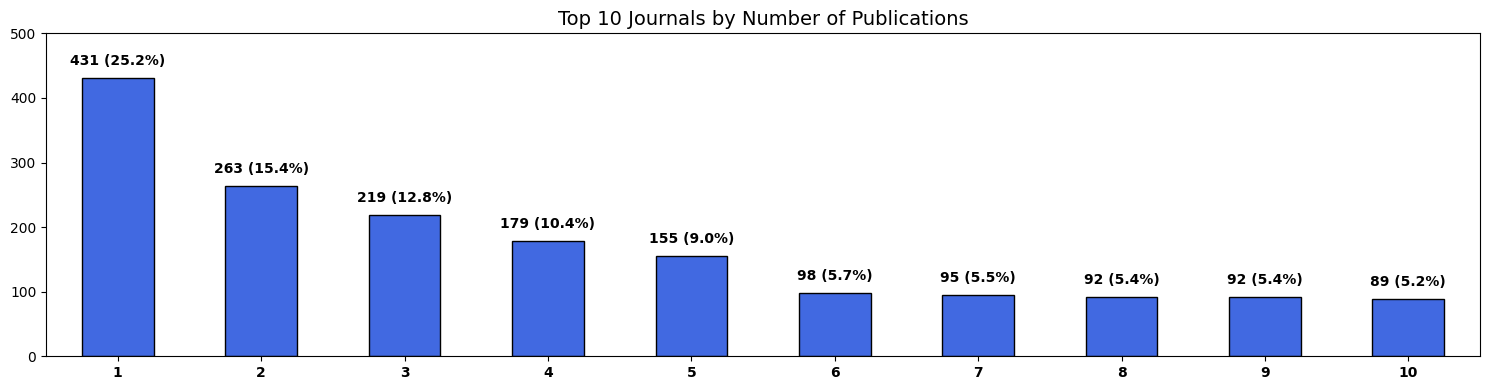

,Journal,Count,Percent
1,Lecture Notes in Computer Science (including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics),431,25.2%
2,Finance Research Letters,263,15.4%
3,Lecture Notes in Networks and Systems,219,12.8%
4,ACM International Conference Proceeding Series,179,10.4%
5,IEEE Access,155,9.0%
6,Communications in Computer and Information Science,98,5.7%
7,Journal of Risk and Financial Management,95,5.5%
8,"IEEE International Conference on Blockchain and Cryptocurrency, ICBC 2021",92,5.4%
9,Research in International Business and Finance,92,5.4%
10,CEUR Workshop Proceedings,89,5.2%


In [9]:
top_journals = df['secondary_title'].value_counts().head(10)

plt.figure(figsize=(15, 4))
top_journals.plot(kind='bar', color='royalblue', edgecolor='black')
plt.title("Top 10 Journals by Number of Publications", fontsize=14)
total = top_journals.sum()
for index, value in enumerate(top_journals):
    percentage = f"{value} ({value / total * 100:.1f}%)"
    plt.text(index, value+20, percentage, ha='center', fontsize=10, fontweight='heavy')
plt.xticks(range(len(top_journals)), range(1, 11), fontsize=10, fontweight='heavy', rotation=0)
plt.xlabel(None)
plt.tight_layout()
plt.ylim(0, 500)
plt.show()

top_journals_df = pd.DataFrame(top_journals).reset_index()
top_journals_df.columns = ['Journal', 'Count']
top_journals_df['Percent'] = (top_journals_df['Count'] / top_journals_df['Count'].sum() * 100).round(1).astype(str) + '%'
top_journals_df.index += 1
top_journals_df.style.set_properties(**{'text-align': 'left'})


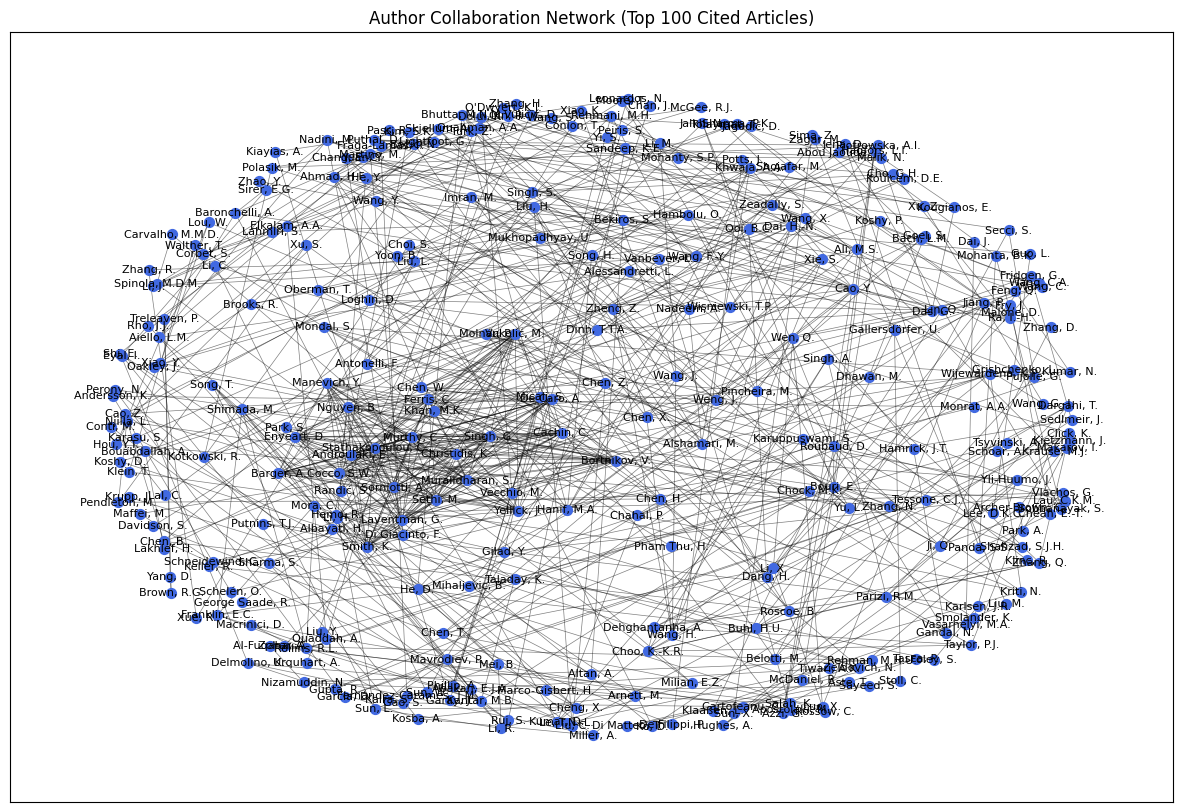

In [40]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

top_100_cited = df.nlargest(100, 'cited_by')

G = nx.Graph()

for authors in top_100_cited['authors'].dropna():
    for author1, author2 in combinations(authors, 2):
        if G.has_edge(author1, author2):
            G[author1][author2]['weight'] += 1
        else:
            G.add_edge(author1, author2, weight=1)

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.9, iterations=50)
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='royalblue')
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Author Collaboration Network (Top 100 Cited Articles)")
plt.show()


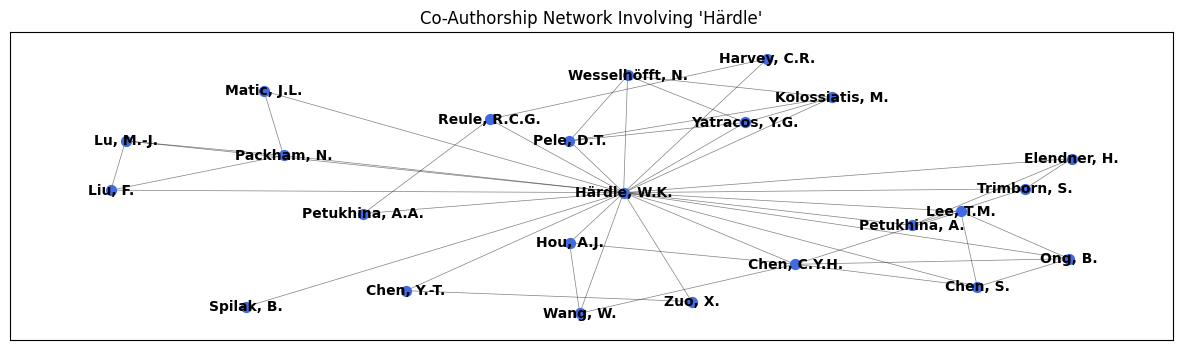

In [44]:
hardle_articles = df[df['authors'].astype(str).str.contains("Härdle", case=False, na=False)]

G = nx.Graph()

for authors in hardle_articles['authors'].dropna():
    if isinstance(authors, list):
        for author1, author2 in combinations(authors, 2):
            if G.has_edge(author1, author2):
                G[author1][author2]['weight'] += 1
            else:
                G.add_edge(author1, author2, weight=1)

# Plot the network
plt.figure(figsize=(15, 4))
pos = nx.spring_layout(G, k=0.9)  # Using spring layout
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='royalblue')
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='heavy')

plt.title("Co-Authorship Network Involving 'Härdle'")
plt.show()

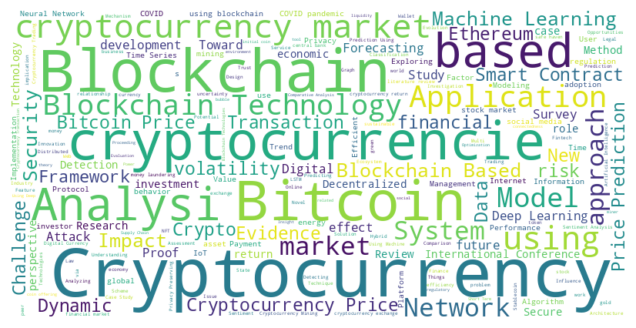

In [13]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

titles = " ".join(df["title"].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(titles)

plt.figure(figsize=(15, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


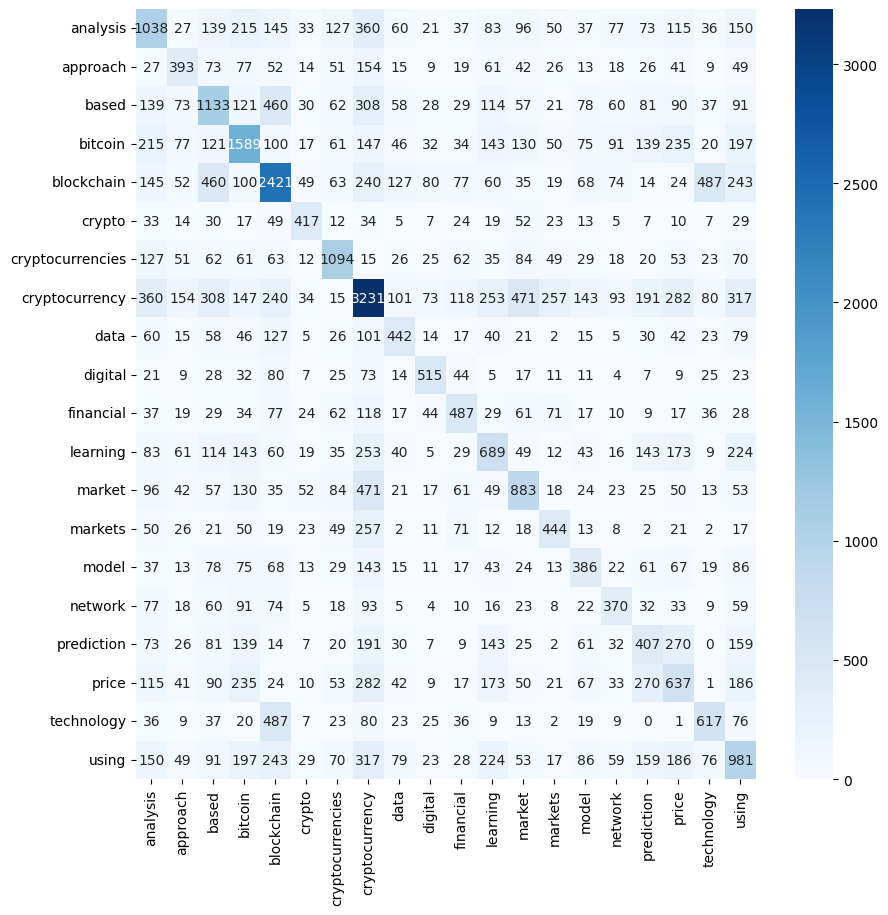

In [18]:
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df["title"].dropna())
keywords = vectorizer.get_feature_names_out()

co_occurrence_matrix = (X.T * X).toarray()
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=keywords, columns=keywords)

plt.figure(figsize=(10, 10))
sns.heatmap(co_occurrence_df, cmap='Blues', annot=True, fmt='d')
plt.show()


In [45]:
unique_keywords = list(set(itertools.chain.from_iterable(df['keywords'])))
unique_keywords = [kw.strip() for kw in unique_keywords if kw.strip()]
total_keywords = len(unique_keywords)

In [10]:
len(unique_keywords)

223

In [80]:
df.columns

Index(['Authors', 'Author full names', 'Author(s) ID', 'Title', 'Year',
       'Source title', 'Volume', 'Issue', 'Art. No.', 'Page start', 'Page end',
       'Page count', 'Cited by', 'DOI', 'Link', 'Affiliations',
       'Authors with affiliations', 'Abstract', 'Author Keywords',
       'Index Keywords', 'Molecular Sequence Numbers', 'Chemicals/CAS',
       'Tradenames', 'Manufacturers', 'Funding Details', 'Funding Texts',
       'References', 'Correspondence Address', 'Editors', 'Publisher',
       'Sponsors', 'Conference name', 'Conference date', 'Conference location',
       'Conference code', 'ISSN', 'ISBN', 'CODEN', 'PubMed ID',
       'Language of Original Document', 'Abbreviated Source Title',
       'Document Type', 'Publication Stage', 'Open Access', 'Source', 'EID'],
      dtype='object')